# Linear Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt

X_train = np.loadtxt('datasets/lin_reg_train.txt', usecols=0)
y_train = np.loadtxt('datasets/lin_reg_train.txt', usecols=1)
X_test = np.loadtxt('datasets/lin_reg_test.txt', usecols=0)
y_test = np.loadtxt('datasets/lin_reg_test.txt', usecols=1)


RMSE on the training set: 0.4121780156736108
RMSE on the test set: 0.38428816992597875


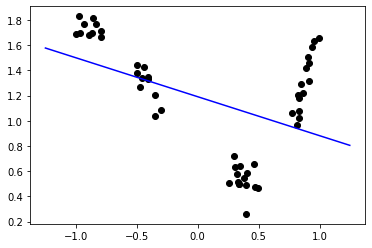

In [2]:
class Linear_Regression():
    def feature_transformation(self, X):
        transformation = np.column_stack((X, np.ones(X.shape[0]))) # homogenous coordinates
        
        for i in range(2, self.degree+1): # basis functions for higher degree polynomial
            transformation = np.column_stack((X**i, transformation))
        return transformation
    
    def fit(self, X_train, y_train, ridge=1, degree=1):
        self.X_train = X_train
        self.y_train = y_train
        self.degree = degree
        X_train = self.feature_transformation(X_train)
        
        self.param = np.linalg.inv(X_train.T@X_train + ridge * np.identity(X_train.shape[1]))@X_train.T@y_train
        return self.param
    
    def predict(self, data):
        data = self.feature_transformation(data)
        return data@self.param
    
    def plot_model(self):
        plt.plot(self.X_train, self.y_train, 'ko')
        line_points = np.linspace(min(self.X_train) - 0.25, max(self.X_train) + 0.25, 100)
        plt.plot(line_points, self.predict(line_points), 'b-')
        
    def rmse(self, X, y):
        predictions = self.predict(X)
        return np.sqrt(((predictions - y) ** 2).mean())
        
    
lin_reg = Linear_Regression()
lin_reg.fit(X_train, y_train, ridge=0.01)
lin_reg.plot_model()
print("RMSE on the training set:", lin_reg.rmse(X_train, y_train))
print("RMSE on the test set:", lin_reg.rmse(X_test, y_test))

plt.savefig('lin_model.png')



RMSE on the training set: 0.2120144726596861
RMSE on the test set: 0.21687242714148738


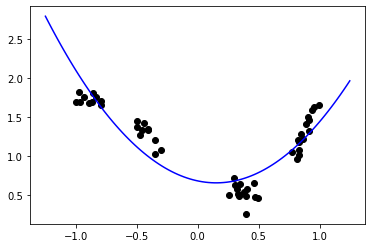

In [3]:
lin_reg.fit(X_train, y_train, ridge=0.01, degree=2)
lin_reg.plot_model()
print("RMSE on the training set:", lin_reg.rmse(X_train, y_train))
print("RMSE on the test set:", lin_reg.rmse(X_test, y_test))
plt.savefig('lin_model_2.png')

RMSE on the training set: 0.0870682129548175
RMSE on the test set: 0.10835803719738023


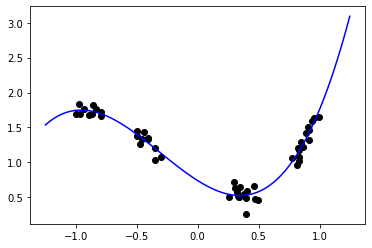

In [4]:
lin_reg.fit(X_train, y_train, ridge=0.01, degree=3)
lin_reg.plot_model()
print("RMSE on the training set:", lin_reg.rmse(X_train, y_train))
print("RMSE on the test set:", lin_reg.rmse(X_test, y_test))
plt.savefig('lin_model_3.png')

RMSE on the training set: 0.08701261306638178
RMSE on the test set: 0.1066623982096425


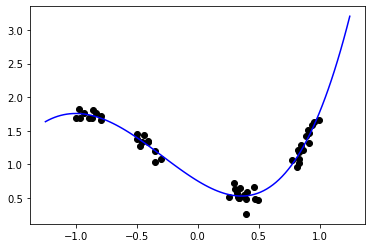

In [5]:
lin_reg.fit(X_train, y_train, ridge=0.01, degree=4)
lin_reg.plot_model()
print("RMSE on the training set:", lin_reg.rmse(X_train, y_train))
print("RMSE on the test set:", lin_reg.rmse(X_test, y_test))
plt.savefig('lin_model_4.png')

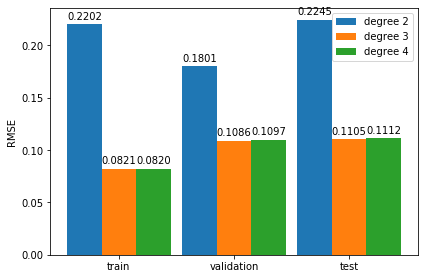

In [6]:
def cross_validation(model, X, y, X_test, y_test):
    # split the data into 5 distinct subsets
    X_subsets = np.split(X, 5)
    y_subsets = np.split(y, 5)
    
    # One row for each polynomial (degree 2, 3, 4), the columns are the mean train, validation and test RMSE 
    scores = np.zeros((3,3))
    
    for i in range(5):
        X_train = np.concatenate(X_subsets[0:-1])
        y_train = np.concatenate(y_subsets[0:-1])
        X_val = np.asarray(X_subsets[-1])
        y_val = np.asarray(y_subsets[-1])

        for i in range(2, 5):
            # train the model with subset 1-4 with degrees 2, 3 and 4
            model.fit(X_train, y_train, ridge=0.01, degree=i)
            # compute train, validation and test RMSE
            scores[i-2] += [model.rmse(X_train, y_train), model.rmse(X_val, y_val), model.rmse(X_test, y_test)]
    
        # cycle through the subsets
        X_subsets = np.roll(X_subsets, 1)
        y_subsets = np.roll(y_subsets, 1)
    
    return scores / 5


scores = cross_validation(Linear_Regression(), X_train, y_train, X_test, y_test)

labels = ["train", "validation", "test"]
scores_degree2 = scores[0]
scores_degree3 = scores[1]
scores_degree4 = scores[2]
x = np.arange(len(labels)) # the label locations
width = 0.3 # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, scores_degree2, width, label='degree 2')
rects2 = ax.bar(x, scores_degree3, width, label='degree 3')
rects3 = ax.bar(x + width, scores_degree4, width, label='degree 4')

ax.set_ylabel('RMSE')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper right')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.{}f}'.format(height, 4),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

        
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
fig.tight_layout()
plt.savefig('cross_val.png')

In [42]:
from scipy.stats import multivariate_normal

class Bayesian_Linear_Regression():
    def feature_transformation(self, X, degree):
        transformation = np.column_stack((X, np.ones(X.shape[0]))) # homogenous coordinates
        
        for i in range(2, degree+1): # basis functions for higher degree polynomial
            transformation = np.column_stack((X**i, transformation))
        return transformation
    
    
    def predictive_distribution(self, x, X_train, y_train, a=0.01, b=100, degree=1, se=False, se_b=10):   
        if (se):
            X_train = self.se_features(X_train, b=se_b)
            x = self.se_features(x, b=se_b)
        else: 
            X_train = self.feature_transformation(X_train, degree)
            x = self.feature_transformation(x, degree)
        
        mean = x@np.linalg.inv(a/b * np.identity(X_train.shape[1]) + X_train.T@X_train)@X_train.T@y_train 
        variance = 1/b + x@np.linalg.inv(a * np.identity(X_train.shape[1]) + b * X_train.T@X_train)@x.T
        return mean, variance
        
    
    def plot_model(self, X_test, X_train, y_train, mean, deviations):
        deviations = np.sqrt(np.diag(variance))
        
        sort = np.argsort(X_test)
        X_test = X_test[sort]
        mean = mean[sort]
        deviations = deviations[sort]
        
        # plot the training data as black dots
        plt.plot(X_train, y_train, 'ko')
        
        # plot the mean of the predictive distribution as a blue line
        plt.plot(X_test, mean, 'b-')
        
        
        # plot the 1, 2, 3 standard deviations
        plt.fill_between(X_test, mean, mean + deviations, color='darkblue', alpha=0.5)
        plt.fill_between(X_test, mean, mean - deviations, color='darkblue', alpha=0.5)
        plt.fill_between(X_test, mean + deviations, mean + 2*deviations, color="cornflowerblue", alpha=0.5)
        plt.fill_between(X_test, mean - deviations, mean - 2*deviations, color='cornflowerblue', alpha=0.5)
        plt.fill_between(X_test, mean + 2*deviations, mean + 3*deviations, color='lavender')
        plt.fill_between(X_test, mean - 2*deviations, mean - 3*deviations, color='lavender')
        
        
    def rmse(self, x, y, X_train, y_train, mean):
        return np.sqrt(((mean - y) ** 2).mean())
    
    def average_log_likelihood(self, Y, mean, variance):
        def log_gaussian(x, mean, variance):
            return np.log(np.exp(-0.5 * (x - mean)**2 / variance)/np.sqrt(2* np.pi * variance))
            
        deviations = np.sqrt(np.diag(variance))
        return sum([log_gaussian(Y[i], mean[i], deviations[i]) for i in range(len(mean))])
    
    
    def log_marginal_likelihood(self, x, y, variance, n=3, k=20, lmbda=0.01):
        phi = self.se_features(x, k=20, b=10)
        print(variance)
        A = 1/variance * phi@phi.T + lmbda * np.identity(phi.shape[0])
        mu = 1/variance * np.linalg.inv(A) * phi * y
        
        return (k+1)/2 * np.log(lmbda) - n/2 * np.log(variance) \
                - 0.5 * numpy.linalg.norm((y - phi.T@mu), ord=2) ** 2 / variance \
                - 0.5 * np.log(np.det(A)) - n/2 * log(2 * np.pi)
    
    
    def se_features(self, x, k=20, b=10):
        result = np.array([[np.exp(-0.5*b * (i - ((j+1)*0.1 - 1))**2) for i in x] for j in range(k)])
        result = np.r_[result, [np.ones_like(result[0])]]
        return result.T
 


Train RMSE 0.4121779259165973
Train Log Likelihood -30.596841655655542
Test RMSE 0.38434085452132943
Test Log Likelihood -50.230892891762295


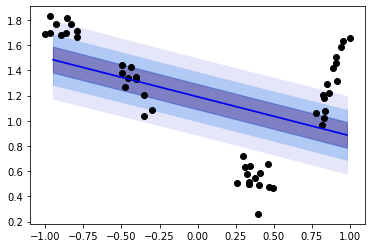

In [43]:
bay_reg = Bayesian_Linear_Regression()

mean, variance = bay_reg.predictive_distribution(X_train, X_train, y_train, degree=1)
print("Train RMSE", bay_reg.rmse(X_train, y_train, X_train, y_train, mean))
print("Train Log Likelihood", bay_reg.average_log_likelihood(y_train, mean, variance))
#print("Log Marginal Likelihood", bay_reg.log_marginal_likelihood(X_train, y_train, variance))

mean, variance = bay_reg.predictive_distribution(X_test, X_train, y_train, degree=1)
print("Test RMSE", bay_reg.rmse(X_test, y_test, X_train, y_train, mean))
print("Test Log Likelihood", bay_reg.average_log_likelihood(y_test, mean, variance))

bay_reg.plot_model(X_test, X_train, y_train, mean, variance)

plt.savefig('lin_model.png')


Train RMSE 0.08160941530985176
Train Log Likelihood 8.058715965489906
Test RMSE 0.14341009681147562
Test Log Likelihood -0.2833839628779645


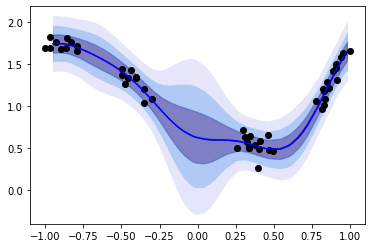

In [21]:
mean, variance = bay_reg.predictive_distribution(X_train, X_train, y_train, se=True)
print("Train RMSE", bay_reg.rmse(X_train, y_train, X_train, y_train, mean))
print("Train Log Likelihood", bay_reg.average_log_likelihood(y_train, mean, variance))

mean, variance = bay_reg.predictive_distribution(X_test, X_train, y_train, se=True)
print("Test RMSE", bay_reg.rmse(X_test, y_test, X_train, y_train, mean))
print("Test Log Likelihood", bay_reg.average_log_likelihood(y_test, mean, variance))

bay_reg.plot_model(X_test, X_train, y_train, mean, variance)

Train RMSE 0.08241342497750263
Train Log Likelihood -47.74762389750824
Test RMSE 0.11618310002274984
Test Log Likelihood -101.72447274352486



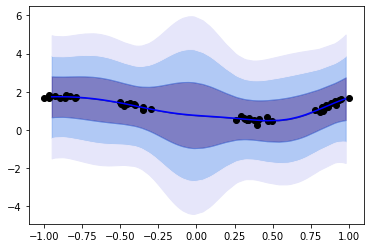

In [22]:
b_value=1
mean, variance = bay_reg.predictive_distribution(X_train, X_train, y_train, se=True, b=b_value)
print("Train RMSE", bay_reg.rmse(X_train, y_train, X_train, y_train, mean))
print("Train Log Likelihood", bay_reg.average_log_likelihood(y_train, mean, variance))
        
mean, variance = bay_reg.predictive_distribution(X_test, X_train, y_train, se=True, b=b_value)
print("Test RMSE", bay_reg.rmse(X_test, y_test, X_train, y_train, mean))
print("Test Log Likelihood", bay_reg.average_log_likelihood(y_test, mean, variance), end="\n\n")
    
bay_reg.plot_model(X_test, X_train, y_train, mean, variance)
        

Train RMSE 0.0818409480140463
Train Log Likelihood -19.502770590729465
Test RMSE 0.12833290605797604
Test Log Likelihood -48.95384464998606



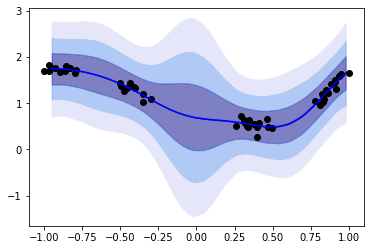

In [23]:
b_value=10
mean, variance = bay_reg.predictive_distribution(X_train, X_train, y_train, se=True, b=b_value)
print("Train RMSE", bay_reg.rmse(X_train, y_train, X_train, y_train, mean))
print("Train Log Likelihood", bay_reg.average_log_likelihood(y_train, mean, variance))
        
mean, variance = bay_reg.predictive_distribution(X_test, X_train, y_train, se=True, b=b_value)
print("Test RMSE", bay_reg.rmse(X_test, y_test, X_train, y_train, mean))
print("Test Log Likelihood", bay_reg.average_log_likelihood(y_test, mean, variance), end="\n\n")
    
bay_reg.plot_model(X_test, X_train, y_train, mean, variance)

Train RMSE 0.08160941530985176
Train Log Likelihood 8.058715965489906
Test RMSE 0.14341009681147562
Test Log Likelihood -0.2833839628779645



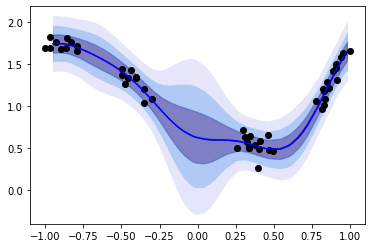

In [24]:
b_value=100
mean, variance = bay_reg.predictive_distribution(X_train, X_train, y_train, se=True, b=b_value)
print("Train RMSE", bay_reg.rmse(X_train, y_train, X_train, y_train, mean))
print("Train Log Likelihood", bay_reg.average_log_likelihood(y_train, mean, variance))
        
mean, variance = bay_reg.predictive_distribution(X_test, X_train, y_train, se=True, b=b_value)
print("Test RMSE", bay_reg.rmse(X_test, y_test, X_train, y_train, mean))
print("Test Log Likelihood", bay_reg.average_log_likelihood(y_test, mean, variance), end="\n\n")
    
bay_reg.plot_model(X_test, X_train, y_train, mean, variance)

In [48]:
a = np.aray([0, 1, 2])
np.append(a, np.zeros((2, 1))r

SyntaxError: unexpected EOF while parsing (<ipython-input-48-edd5214333ce>, line 2)

In [58]:
a = np.array([1, 2, 3 , 4, 5])

def test(a):
    a = np.array(a)
    a[2:4] = 0
    print(a)

test(a)
print(a)

[1 2 0 0 5]
[1 2 3 4 5]


In [53]:
a

array([1, 2, 0, 0, 5])

In [63]:
b = np.array([[1, 2, 3], [2,3,5], [3, 4, 5]])
print(b)
b[:,1:]=0
print(b)

[[1 2 3]
 [2 3 5]
 [3 4 5]]
[[1 0 0]
 [2 0 0]
 [3 0 0]]
